# Handin Exercise 6

Create a module containing a class with the following methods:
1. __init__(self, url_list)
2. download(url,filename) raises NotFoundException when url returns 404
3. multi_download() uses threads to download multiple urls as text and stores filenames as a property
4. __iter__() returns an iterator
5. __next__() returns the next filename (and stops when there are no more)
6. urllist_generator() returns a generator to loop through the urls
7. avg_vowels(text) - a rough estimate on readability returns average number of vowels in the words of the text
8. hardest_read() returns the filename of the text with the highest vowel score (use all the cpu cores on the computer for this work.

In [1]:

from concurrent.futures import ProcessPoolExecutor
from concurrent.futures import ThreadPoolExecutor
#from modules import webget
import glob
import multiprocessing
import time
import requests
import os
import matplotlib.pyplot as plt



print(os.listdir(os.getcwd()))
if os.path.exists('downloads'):
    files = glob.glob('./downloads/*')
    for f in files:
        os.remove(f) 
else:
        os.makedirs('downloads')




['.ipynb_checkpoints', 'downloads', 'Exercises.ipynb', 'Modules']


In [2]:

class book_reader():
    def __init__(self, url_list, filenames):
        self.url_list = url_list
        self.filenames = filenames

    def __iter__(self, start = 0 ):
        self.count = start 

    def __next__(self):
        "Return the next filename (stops when no more)"
        if self.count < len(self.url_list): 
            self.count +=1
            return self.url_list(self.count-1)
        else: 
            raise StopIteration
        
    def urllist_generator(self):
        for url in self.url_list: 
            yield url

    def download(self, url, filename):
        "Downloads from the url, to the file specified. Throws NotFoundException if 404"
        r = requests.get(url)
        if(r.status_code == 404):
            raise Exception('URL ' + url + " NOT FOUND")
        #print('',r.json()['url'])
        open('./downloads/' + filename + ".txt", 'wb').write(r.content)

    def multi_download(self):
        """Uses threads to download multiple urls as text and stores filenames as a property."""
        pool = ThreadPoolExecutor(len(self.url_list))
        pool.map(lambda x, y: self.download(x, y),
                 self.url_list, self.filenames)
        
    def urllist_generator(self):
        """Returns a generator to loop through the urls"""
        for url in self.url_list:
            yield (url)

    def avg_vowels(self, text):
        """Rough estimate on readability - avg number of vowels in the words of the text"""
        vowels = "AaEeIiOoUu"
        count = len([char for char in text if char in vowels])
        return count

    
    def get_file_contents(self, filename):
        os.chdir('/home/jovyan/my_notebooks/Week6/downloads/')
        with open(filename+".txt") as file:
            contents = file.read()
            return contents
    
    
    def hardest_read(self):
        books = []
        file_list = []
        for file in self.filenames:
            contents = self.get_file_contents(file)
            books.append(contents)
            file_list.append(file)           
        with ProcessPoolExecutor(max_workers=os.cpu_count()) as executor:
            res = executor.map(self.avg_vowels, books)
        
        vowels = list(res)
        results = dict(zip(file_list, vowels))
            
        return (max(results, key = results.get))

    def hardest_read_multiprocess(self):
        result = self.calc_readability()
        return (max(result, key = result.get))
    
    def calc_readability(self):
        with ProcessPoolExecutor(multiprocessing.cpu_count()) as ex:
            results = list(ex.map(self.avg_vowels, self.filenames))
            result = {}
            for x in range(0, len(results)):
                d = {self.filenames[x]:results[x]}
                result.update(d)
        return result

    
    def plot_hardest_read(self):
        results = self.calc_readability()
        book_ids = list(zip(*results))[0]
        readability = list(zip(*results))[1]
        plt.barh(book_ids, readability)
        plt.grid(axis='x')
        plt.ylabel("Book IDs")
        plt.xlabel("Readablilty (Avg vowels pr. word)")
        plt.show()   

In [3]:
if __name__ == "__main__":
    urls = ['https://www.gutenberg.org/files/1342/1342-0.txt',
            'https://www.gutenberg.org/files/11/11-0.txt',
            'http://www.gutenberg.org/cache/epub/1497/pg1497.txt',

            ]
    filenames = [
        'Pride and Prejudice',
        'Alice’s Adventures in Wonderland',
         'The Republic'
    ]

    bookdata = book_reader(urls, filenames)
    bookdata.multi_download()


The Republic
Finished in 0.14 seconds
Alice’s Adventures in Wonderland
Finished in 0.04 seconds


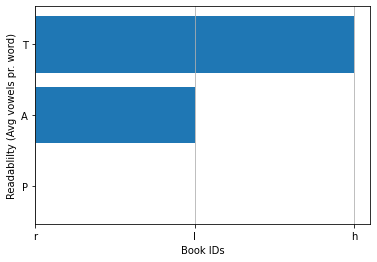

In [4]:

    start = time.perf_counter()
    
    
    print(bookdata.hardest_read())

    finish = time.perf_counter()
    print(f'Finished in {round(finish-start, 2)} seconds')

    start = time.perf_counter()
    print(bookdata.hardest_read_multiprocess())
    finish = time.perf_counter()
    print(f'Finished in {round(finish-start, 2)} seconds')

    bookdata.plot_hardest_read()